In [5]:
import pickle
import glob
import os
import sys
import time
import numpy as np
import pandas as pd 
import multiprocessing as mp 
import openmdao.api as om
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import CubicSpline
from matplotlib.colors import LinearSegmentedColormap

fontsize = 14

In [6]:
## Load SQL Files
def load_OMsql(log):
    print('loading {}'.format(log))
    cr = om.CaseReader(log)
    rec_data = {}
    driver_cases = cr.list_cases('driver')
    cases = cr.get_cases('driver')
    for case in cases:
        for key in case.outputs.keys():
            if key not in rec_data:
                rec_data[key] = []
            rec_data[key].append(case[key])
        
    return rec_data

# print(os.getcwd())
data1 = load_OMsql(r'./output/log_opt_rs_0.sql')
data2 = load_OMsql(r'./output/log_opt_rs_1.sql')
# data3 = load_OMsql(r'..\res\opts\llfvw_eb\output\log_iea22mw_umaine.sql')
# data4 = load_OMsql(r'..\res\opts\llfvw_fpm\output\log_iea22mw_umaine.sql')



loading ./output/log_opt_rs_0.sql


driver
rank0:NLopt_LN_COBYLA|0
rank0:NLopt_LN_COBYLA|1
rank0:NLopt_LN_COBYLA|2
rank0:NLopt_LN_COBYLA|3
rank0:NLopt_LN_COBYLA|4
rank0:NLopt_LN_COBYLA|5
rank0:NLopt_LN_COBYLA|6


loading ./output/log_opt_rs_1.sql


driver
rank0:NLopt_LN_COBYLA|0
rank0:NLopt_LN_COBYLA|1
rank0:NLopt_LN_COBYLA|2
rank0:NLopt_LN_COBYLA|3
rank0:NLopt_LN_COBYLA|4
rank0:NLopt_LN_COBYLA|5
rank0:NLopt_LN_COBYLA|6
rank0:NLopt_LN_COBYLA|7
rank0:NLopt_LN_COBYLA|8
rank0:NLopt_LN_COBYLA|9


In [7]:
# Print available keys in SQL files
for key1, key2 in zip(data1, data2):
    print(f"{key1:<35} | {key2:<35}")
    

aeroelastic_qblade.Max_PtfmPitch    | aeroelastic_qblade.Max_PtfmPitch   
aeroelastic_qblade.qblade_failed    | aeroelastic_qblade.qblade_failed   
floatingse.platform_mass            | floatingse.platform_mass           
floating.jointdv_0                  | floating.jointdv_0                 


Error processing floatingse.pitch_period: 'floatingse.pitch_period'
Error processing floatingse.heave_period: 'floatingse.heave_period'
Error processing floatingse.constr_fixed_margin: 'floatingse.constr_fixed_margin'
Error processing floatingse.constr_variable_margin: 'floatingse.constr_variable_margin'
Error processing floatingse.constr_freeboard_heel_margin: 'floatingse.constr_freeboard_heel_margin'
Error processing floatingse.constr_draft_heel_margin: 'floatingse.constr_draft_heel_margin'
Error processing floatingse.constr_fairlead_wave: 'floatingse.constr_fairlead_wave'
Error processing aeroelastic_qblade.max_nac_accel: 'aeroelastic_qblade.max_nac_accel'
Error processing aeroelastic_qblade.rotor_overspeed: 'aeroelastic_qblade.rotor_overspeed'


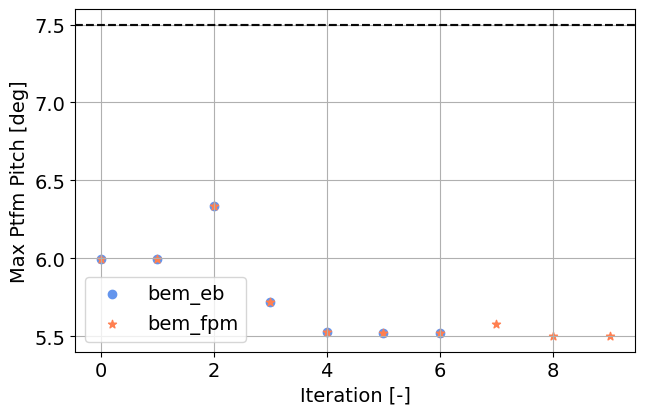

In [8]:
## CONSTRAINTS
# Plot design variables, constraints, and merit figures (openmdao inputs/outputs) vs. iteration
y_vars = [ # channel key corresponding y_label
        # ['floatingse.constr_draft_heel_margin', 'survival heel margin [-]'],
        ['floatingse.pitch_period', 'pitch period [s]'],
        ['floatingse.heave_period', 'heave period [s]'],
        ['floatingse.constr_fixed_margin', 'fixed_ballast_capacity []'],
        ['floatingse.constr_variable_margin', 'variable_ballast_capacity []'],
        ['floatingse.constr_freeboard_heel_margin', 'freeboard_margin [-]'],
        ['floatingse.constr_draft_heel_margin', 'draft_margin [-]'],
        ['floatingse.constr_fairlead_wave', 'fairlead_depth [m]'],
        ['aeroelastic_qblade.max_nac_accel', '$max. nacelle accel [deg/s2]'],
        ['aeroelastic_qblade.rotor_overspeed', 'gen overspeed [-]'],
        # ['aeroelastic_qblade.avg_pitch_travel', 'avg. pitch travel [deg/s]'], 
        # ['aeroelastic_qblade.Std_PtfmPitch', 'Std Ptfm Pitch [deg]'],
        ['aeroelastic_qblade.Max_PtfmPitch', 'Max Ptfm Pitch [deg]'],        
        # ['aeroelastic_qblade.max_pitch_rate_sim', '$max. pitch rate [deg/s]'],
        # ['aeroelastic_qblade.Mean_PtfmPitch', 'Mean Ptfm Pitch [deg]'],

]

dv_column = 2 # Column index
n_iterations = 10  # Number of iterations to plot

n_plots = len(y_vars)
n_cols = 3  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed

# Create the grid of subplots
fig, axs = plt.subplots(n_rows, n_cols)

# axs = [axs]
axs = axs.flatten()

sp_size = 2
fig.set_size_inches(n_cols * 6, n_rows *4)
# colors = ['darkblue', 'orange', 'slateblue', 'tomato']  # PC and S color

colors = ['cornflowerblue', 'coral', 'grey', "#679461"]  # Define your color palette
labels = ['bem_eb', 'bem_fpm', 'llfvw_eb', 'llfvw_fpm']  # Labels for each data series
# labels = ['bem_eb', 'llfvw_eb']  # Labels for each data series
# linestyles = ['-', '--', '-', '--']  # Line styles for the corresponding series
markers = ['o', '*', 'd', '*']  # Markers: 'o' for PC, 'x' for S

constraints = {
                'floatingse.pitch_period': [20,33],
                'floatingse.heave_period': [14, 18],
                'aeroelastic_qblade.max_nac_accel': [3],
                'aeroelastic_qblade.rotor_overspeed': [0.2],
                'aeroelastic_qblade.avg_pitch_travel': [0.085],
                'aeroelastic_qblade.Max_PtfmPitch': [7.5],
                }

i_ax = 0
for yv in y_vars:
    try:
        # Plot data with scatter, applying color, label, and marker accordingly
        for idx, (data, label, color, marker) in enumerate(zip([data1, data2], labels, colors, markers)):
            y_data = np.squeeze(data[yv[0]][:n_iterations])  # Extract data for current variable
            if y_data.ndim > 1 and y_data.shape[1] > 1:
                y_data = y_data[:, dv_column]  # Select the correct column if data is multidimensional
            

            # Scatter
            axs[i_ax].scatter(np.arange(len(y_data)), y_data, label=label, color=color, marker=marker)

            # Line plot
            # axs[i_ax].plot(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1, marker='')
            
            # Constraint
            if yv[0] in constraints:
                axs[i_ax].axhline(y=constraints[yv[0]][0], color='black', linestyle='--',alpha=0.8)
                if len(constraints[yv[0]]) > 1:
                    axs[i_ax].axhline(y=constraints[yv[0]][1], color='black', linestyle='--', alpha=0.8)

            
        # Set labels and grid
        axs[i_ax].set_xlabel('Iteration [-]', fontsize=fontsize)
        axs[i_ax].set_ylabel(f"{yv[1]}", fontsize=fontsize)
        axs[i_ax].grid()
        axs[i_ax].tick_params(axis='both', which='major', labelsize=fontsize)

        # Display the legend
        if i_ax == 0:
            axs[i_ax].legend(loc='best', fontsize=fontsize)
            # axs[i_ax].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

        # Increment to the next axis for the next y-variable
        i_ax += 1

    except Exception as e:
        print(f"Error processing {yv[0]}: {e}")


# Remove any unused subplots
for i in range(i_ax, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout(pad=1)
# fig.savefig(".\\figures\\Constraints.pdf", format='pdf', bbox_inches='tight')
plt.show()

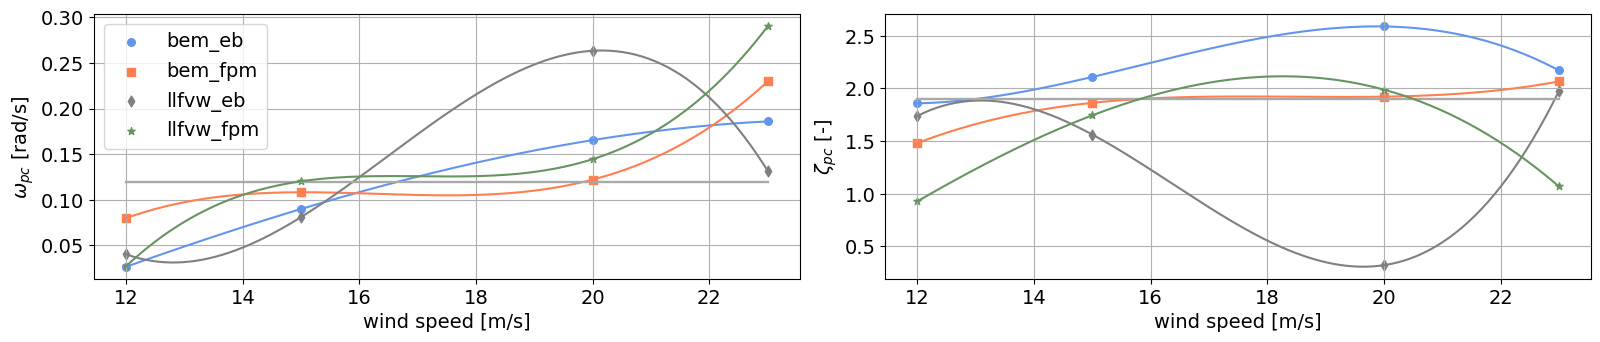

In [ ]:
## DVs -Control and MERIT FIGURE

y_vars = [ # channel key corresponding y_label
        ['tune_rosco_ivc.omega_pc', '$\\omega_{pc}$ [rad/s]'],
        ['tune_rosco_ivc.zeta_pc', '$\\zeta_{pc}$ [-]'],
        # ['sse_tune.tune_rosco.PC_Kp', '$K_p$ [s]'],
        # ['sse_tune.tune_rosco.PC_Ki', '$K_i$ [-]'],
        # ['tune_rosco_ivc.Kp_float', '$k_{float}$ [s]'],
        # ['tune_rosco_ivc.ptfm_freq', '$\\omega_{float}$ [rad/s]'],
]

n_iterations = 150  # Number of iterations to plot

ws_control_points = [12,15,20,23]

n_plots = len(y_vars)
n_cols = 3  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed

# Create the grid of subplots
fig, axs = plt.subplots(n_rows, n_cols)

axs = axs.flatten()

sp_size = 2
fig.set_size_inches(n_cols * 8, n_rows * 3.5)
# colors = ['darkblue', 'orange', 'slateblue', 'tomato']  # PC and S color

colors = ['cornflowerblue', 'coral', 'grey', "#679461"]  # Define your color palette
labels = ['bem_eb', 'bem_fpm', 'llfvw_eb', 'llfvw_fpm']  # Labels for each data series
# linestyles = ['-', '--', '-', '--']  # Line styles for the corresponding series
markers = ['o', 's', 'd', '*']  # Markers: 'o' for PC, 'x' for S

i_ax = 0
for yv in y_vars:
    try:
        # Plot data with scatter, applying color, label, and marker accordingly
        for idx, (data, label, color, marker) in enumerate(zip([data1, data2, data4], labels, colors, markers)):
           
            y_data = np.squeeze(data[yv[0]][:n_iterations])  # Extract data for current variable
            
            if y_data.ndim > 1 and y_data.shape[1] > 1:
                n_iters = y_data.shape[0]

                # Create a custom colormap from gray to the final color
                cmap_custom = LinearSegmentedColormap.from_list(
                    f"gray_to_{label}", ["#A9A9A9", color]
                )
                colors_iter = cmap_custom(np.linspace(0, 1, n_iters))

                # Plot every 3rd iteration to reduce clutter
                for i_iter in range(0, n_iters, 150):
                    y_vals = y_data[i_iter]
                    if len(y_vals) != len(ws_control_points):
                        continue
                    try:
                        cs = CubicSpline(ws_control_points, y_vals)
                        ws_fine = np.linspace(min(ws_control_points), max(ws_control_points), 200)
                        axs[i_ax].plot(ws_fine, cs(ws_fine), color=colors_iter[i_iter], alpha=1)
                    except Exception as e:
                        print(f"Skipping spline for iteration {i_iter} of {label}: {e}")

                # Ensure final iteration is shown
                if (n_iters - 1) % 150 != 0:
                    y_final = y_data[-1]
                    try:
                        cs_final = CubicSpline(ws_control_points, y_final)
                        axs[i_ax].plot(ws_fine, cs_final(ws_fine), color=colors_iter[-1], alpha=1)
                    except Exception as e:
                        print(f"Skipping final iteration spline for {label}: {e}")

                # Plot final control points explicitly
                axs[i_ax].scatter(ws_control_points, y_data[-1], color=color, label=label, marker=marker, s=30)
                axs[i_ax].set_xlabel("Wind Speed (m/s)", fontsize=fontsize)
            
            else:
                # axs[i_ax].scatter(np.arange(len(y_data)), y_data, label=label, color=color, axs[i_ax].scatter(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1, marker=marker), marker=marker)
                axs[i_ax].plot(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1, marker='')
                
        # Set labels and grid
        axs[i_ax].set_xlabel('wind speed [m/s]', fontsize=fontsize)
        axs[i_ax].set_ylabel(f"{yv[1]}", fontsize=fontsize)
        axs[i_ax].tick_params(axis='both', which='major', labelsize=fontsize)
        axs[i_ax].grid()

        # Display the legend
        if i_ax == 0:
            axs[i_ax].legend(loc='best', fontsize=fontsize)
            # axs[i_ax].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

        # Increment to the next axis for the next y-variable
        i_ax += 1

    except Exception as e:
        print(f"Error processing {yv[0]}: {e}")

# Remove any unused subplots
for i in range(i_ax, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout(pad=1)
# fig.savefig(".\\figures\\optimal_controller_params.pdf", format='pdf', bbox_inches='tight')
plt.show()


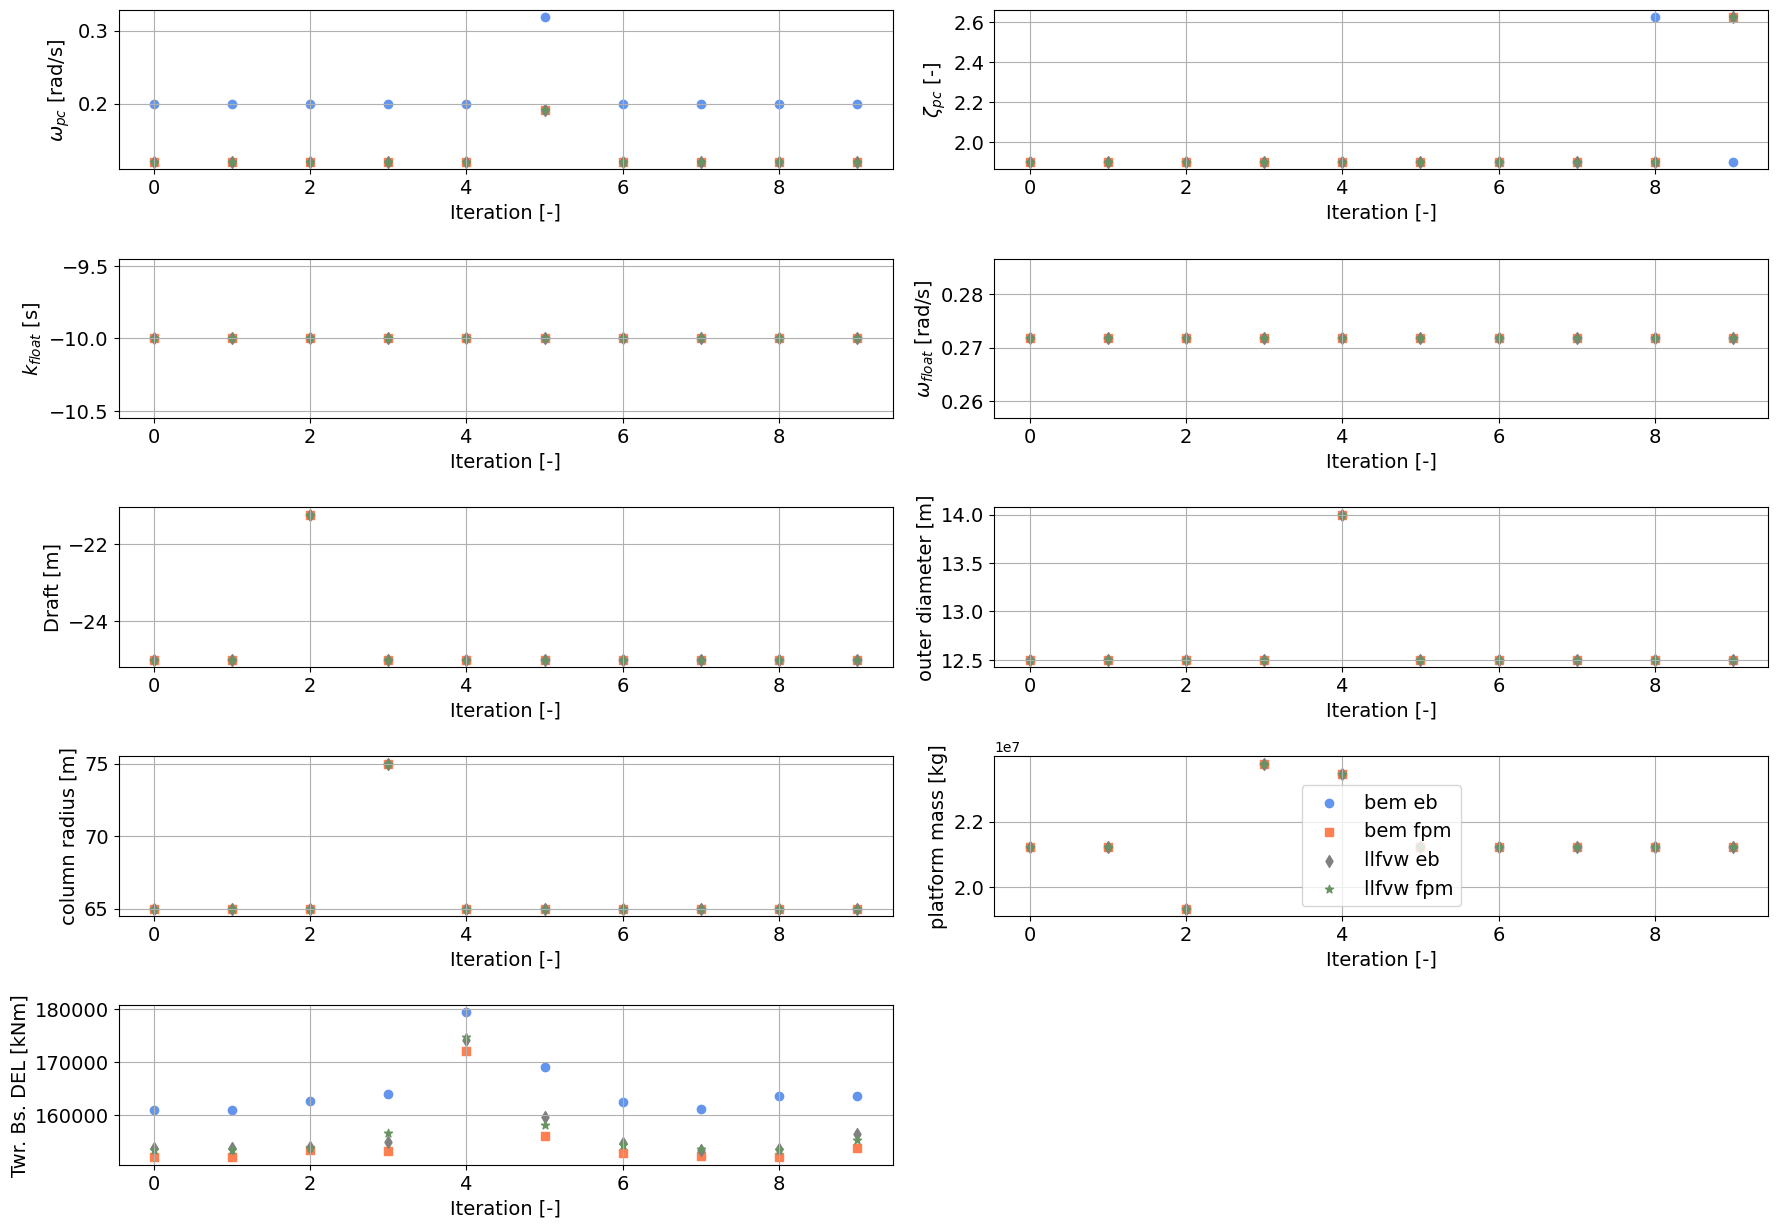

In [ ]:
## DVs and MERIT FIGURE

# Plot design variables, constraints, and merit figures (openmdao inputs/outputs) vs. iteration
y_vars = [ # channel key corresponding y_label
        ['tune_rosco_ivc.omega_pc', '$\\omega_{pc}$ [rad/s]'],
        ['tune_rosco_ivc.zeta_pc', '$\\zeta_{pc}$ [-]'],
        ['tune_rosco_ivc.Kp_float', '$k_{float}$ [s]'],
        ['tune_rosco_ivc.ptfm_freq', '$\\omega_{float}$ [rad/s]'],
        ['floating.jointdv_0', 'Draft [m]'],
        ['floating.memgrp1.outer_diameter_in', 'outer diameter [m]'],
        ['floating.jointdv_1', 'column radius [m]'],
        # ['aeroelastic_qblade.Max_PtfmPitch', 'Max Ptfm Pitch [deg]'],   
        ['floatingse.platform_mass', 'platform mass [kg]'],
        ['aeroelastic_qblade.DEL_TwrBsMyt', 'Twr. Bs. DEL [kNm]'],
        # ['financese_post.lcoe', 'LCOE [$/MWh]'],
]

constraints = {
                'floatingse.pitch_period': [20,33],
                'floatingse.heave_period': [14, 18],
                'aeroelastic_qblade.max_nac_accel': [2.7],
                'aeroelastic_qblade.rotor_overspeed': [0.2],
                'aeroelastic_qblade.avg_pitch_travel': [0.085],
                'aeroelastic_qblade.Max_PtfmPitch': [7.2],
                }
dv_column = 0 # Column index
n_iterations = 10  # Number of iterations to plot

n_plots = len(y_vars)
n_cols = 2  # Fixed number of columns
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed

# Create the grid of subplots
fig, axs = plt.subplots(n_rows, n_cols)
axs = axs.flatten()

sp_size = 2
fig.set_size_inches(n_cols * 9, n_rows * 2.5)
# colors = ['darkblue', 'orange', 'slateblue', 'tomato']  # PC and S color

colors = ['cornflowerblue', 'coral', 'grey', "#679461"]  # Define your color palette
labels = ['bem eb', 'bem fpm', 'llfvw eb', 'llfvw fpm']  # Labels for each data series
# labels = ['llfvw_eb'] 
# linestyles = ['-', '--', '-', '--']  # Line styles for the corresponding series
markers = ['o', 's', 'd', '*']  # Markers: 'o' for PC, 'x' for S

i_ax = 0
for yv in y_vars:
    try:
        # Plot data with scatter, applying color, label, and marker accordingly
        for idx, (data, label, color, marker) in enumerate(zip([data1, data2, data4], labels, colors, markers)):
           
            y_data = np.squeeze(data[yv[0]][:n_iterations])  # Extract data for current variable
            
            if y_data.ndim > 1 and y_data.shape[1] > 1:
                y_data = y_data[:, dv_column]  # Select the correct column if data is multidimensional
                axs[i_ax].scatter(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1, marker=marker)
                # axs[i_ax].plot(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1)
            
            else:
                axs[i_ax].scatter(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1, marker=marker)
                # axs[i_ax].plot(np.arange(len(y_data)), y_data, label=label, color=color, alpha=1, marker='')
            
            # Constraint
            if yv[0] in constraints:
                axs[i_ax].axhline(y=constraints[yv[0]][0], color='black', linestyle='--',alpha=0.8)
                if len(constraints[yv[0]]) > 1:
                    axs[i_ax].axhline(y=constraints[yv[0]][1], color='black', linestyle='--', alpha=0.8)

            
                
        # Set labels and grid
        axs[i_ax].set_xlabel('Iteration [-]', fontsize=fontsize)
        axs[i_ax].set_ylabel(f"{yv[1]}", fontsize=fontsize)
        axs[i_ax].tick_params(axis='both', which='major', labelsize=fontsize)
        axs[i_ax].grid()

        # Display the legend
        if i_ax == 7:
            axs[i_ax].legend(loc='best', fontsize=fontsize)
            # axs[i_ax].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

        # Increment to the next axis for the next y-variable
        i_ax += 1

    except Exception as e:
        print(f"Error processing {yv[0]}: {e}")
# 
# axs[0].set_ylim(-32,-19.5)
# axs[1].set_ylim(9.7,14.2)
# axs[2].set_ylim(61,76)
# Remove any unused subplots
for i in range(i_ax, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout
fig.tight_layout(pad=1.5)
# fig.savefig(".\\figures\\DV_ROSCO_convergence_trends.pdf", format='pdf', bbox_inches='tight')
plt.show()

Reduction of TwrBsMyt at Optimium for bem eb    : -12.59 %
Reduction of TwrBsMyt at Optimium for bem fpm   : -16.39 %
Reduction of TwrBsMyt at Optimium for llfvw eb  : -16.38 %
Reduction of TwrBsMyt at Optimium for llfvw fpm : -17.92 %


C:\Users\behrensdeluna\AppData\Local\Temp\ipykernel_18540\3052362091.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


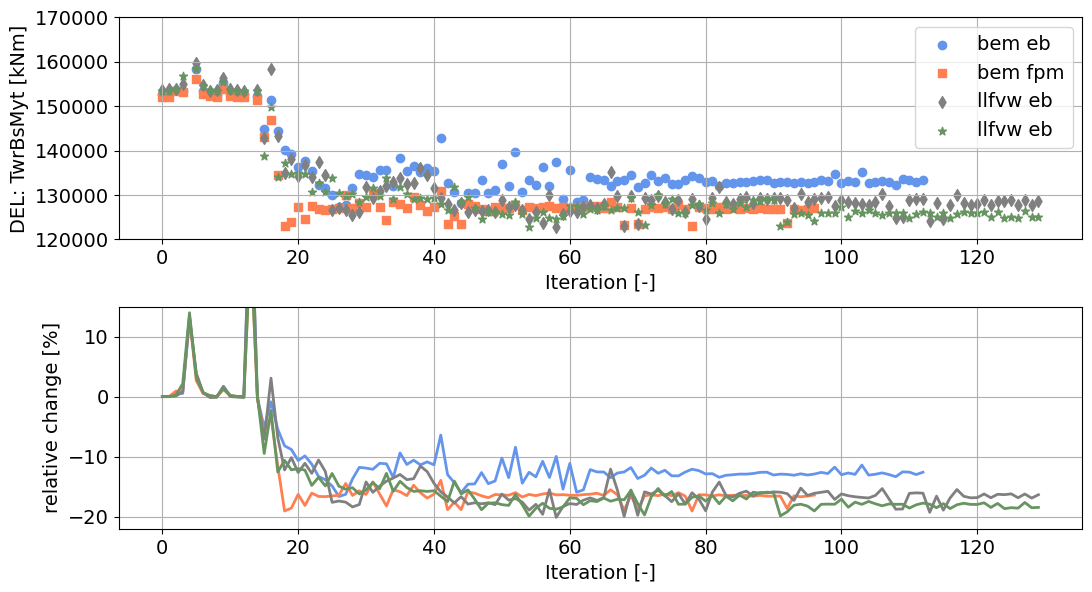

In [ ]:
#Objective convergence
del_vals = [
    np.array(data1['aeroelastic_qblade.DEL_TwrBsMyt']).squeeze(),
    np.array(data2['aeroelastic_qblade.DEL_TwrBsMyt']).squeeze(),
    # np.array(data3['aeroelastic_qblade.DEL_TwrBsMyt']).squeeze(),
    np.array(data4['aeroelastic_qblade.DEL_TwrBsMyt']).squeeze()
        ]
labels = ['bem_eb', 'bem_fpm', 'llfvw_eb', 'llfvw_fpm']
markers = ['o', 's', 'd', '*']
idx_end = 130

rel_delta = []
for i in range(len(del_vals)):
    rel_delta.append(np.diff(del_vals[i]) / np.maximum(np.abs(del_vals[i][:-1]), 1e-6))

global_delta = []
for i in range(len(del_vals)):
    global_delta.append((del_vals[i][:]/del_vals[i][0]-1)*100)

# Create the grid of subplots
fig, axs = plt.subplots(2, 1)

# # Plot the relative change
fig.set_size_inches(11, 6)
labels = [case.replace('_',' ') for case in labels]  # Extract case names from labels

axs[0].scatter(np.arange(len(del_vals[0][:idx_end])), del_vals[0][:idx_end], label=labels[0], color='cornflowerblue', alpha=1.0, marker=markers[0])
axs[0].scatter(np.arange(len(del_vals[1][:idx_end])),del_vals[1][:idx_end], label=labels[1], color='coral', alpha=1.0, marker=markers[1])
axs[0].scatter(np.arange(len(del_vals[2][:idx_end])),del_vals[2][:idx_end], label=labels[2], color='grey', linestyle='-', alpha=1.0, marker=markers[2])
axs[0].scatter(np.arange(len(del_vals[3][:idx_end])),del_vals[3][:idx_end], label=labels[2], color='#679461', linestyle='-', alpha=1.0, marker=markers[3])
axs[0].set_ylabel("DEL: TwrBsMyt [kNm]", fontsize=fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=fontsize)
axs[0].set_xlabel("Iteration [-]", fontsize=fontsize)
axs[0].set_ylim(120e03, 170e03)
axs[0].grid()
axs[0].legend(loc='best', fontsize=fontsize)

markers = ['', '', '', '']
axs[1].plot(np.arange(len(del_vals[0][:idx_end])),global_delta[0][:idx_end], label=labels[0], linewidth=2, color='cornflowerblue', alpha=1.0, marker=markers[0])
axs[1].plot(np.arange(len(del_vals[1][:idx_end])),global_delta[1][:idx_end], label=labels[1], linewidth=2, color='coral', alpha=1.0, marker=markers[1])
axs[1].plot(np.arange(len(del_vals[2][:idx_end])),global_delta[2][:idx_end], label=labels[2], linewidth=2, color='grey', linestyle='-', alpha=1.0, marker=markers[2])
axs[1].plot(np.arange(len(del_vals[3][:idx_end])),global_delta[3][:idx_end], label=labels[2], linewidth=2, color='#679461', linestyle='-', alpha=1.0, marker=markers[3])
axs[1].set_ylabel("relative change [%]", fontsize=fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=fontsize)
axs[1].set_xlabel("Iteration [-]", fontsize=fontsize)
axs[1].set_ylim(-22, 15)
axs[1].grid()


# axs[2].plot(rel_delta[0][:idx_end], label=labels[0], color='cornflowerblue', alpha=1.0, marker='')
# axs[2].plot(rel_delta[1][:idx_end], label=labels[1], color='coral', alpha=1.0, marker='')
# axs[2].plot(rel_delta[2][:idx_end], label=labels[2], color='grey', linestyle='-', alpha=1.0, marker='')
# axs[2].plot(rel_delta[3][:idx_end], label=labels[2], color='#679461', linestyle='-', alpha=1.0, marker='')
# axs[2].set_ylabel("Relative ∆ Twr. Bs. DEL [kNm]")
# axs[2].set_xlabel("Iteration")
# # axs[2].set_ylim(-0.05, 0.05)
# axs[2].grid()
# # axs[2].set_title("Convergence indicator: ∆ DEL/DEL")


for idx, data in enumerate(global_delta):
    global_det_min = np.min(data[:idx_end])
    index_min = np.argmin(data[:idx_end])
    # print(f'Global minimum of {labels[idx]:<{10}}:', global_det_min, ' at iteration:', index_min)
    print(f'Reduction of TwrBsMyt at Optimium for {labels[idx]:<{10}}:', round(global_delta[idx][-1],2) ,'%')
fig.tight_layout(pad=1)
fig.show()

# fig.savefig(".\\figures\\MeritFigure_convergence_trends.pdf", format='pdf', bbox_inches='tight')


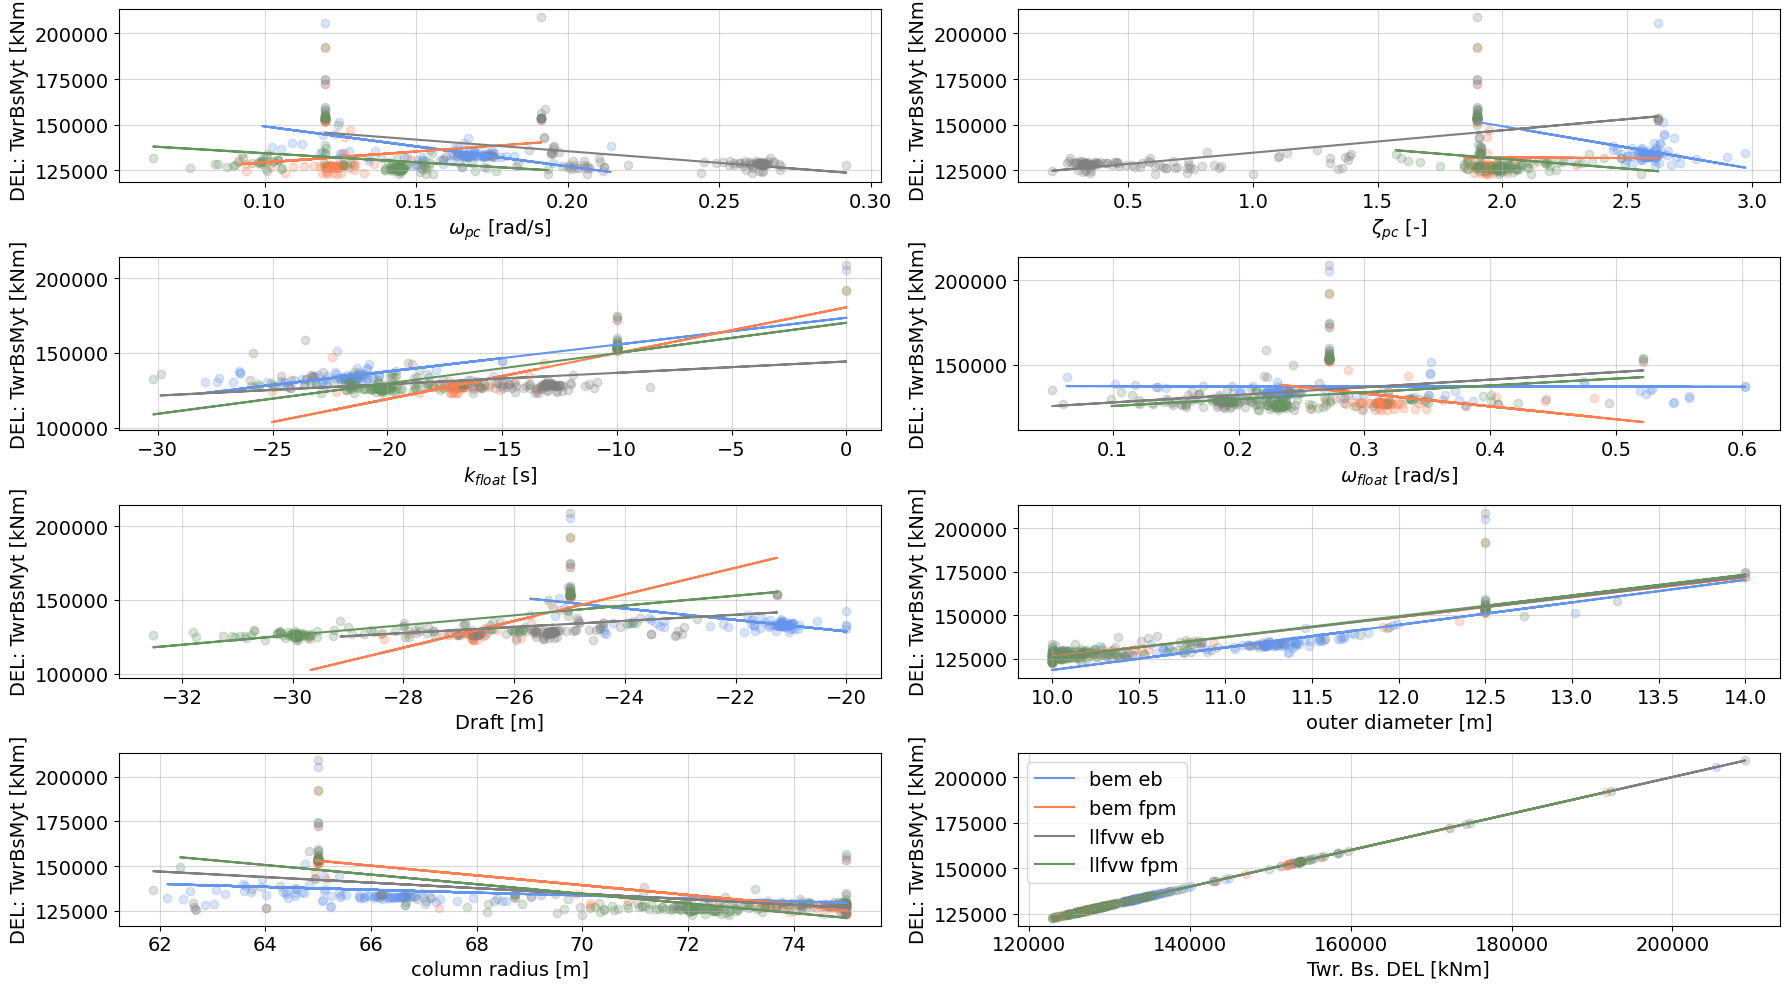

In [93]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score  # Optional: for clarity

y_vars = [ # channel key corresponding y_label
        ['tune_rosco_ivc.omega_pc', '$\\omega_{pc}$ [rad/s]'],
        ['tune_rosco_ivc.zeta_pc', '$\\zeta_{pc}$ [-]'],
        ['tune_rosco_ivc.Kp_float', '$k_{float}$ [s]'],
        ['tune_rosco_ivc.ptfm_freq', '$\\omega_{float}$ [rad/s]'],
        ['floating.jointdv_0', 'Draft [m]'],
        ['floating.memgrp1.outer_diameter_in', 'outer diameter [m]'],
        ['floating.jointdv_1', 'column radius [m]'],
        # ['aeroelastic_qblade.Max_PtfmPitch', 'Max Ptfm Pitch [deg]'],   
        # ['floatingse.platform_mass', 'platform mass [kg]'],
        ['aeroelastic_qblade.DEL_TwrBsMyt', 'Twr. Bs. DEL [kNm]'],
        # ['financese_post.lcoe', 'LCOE [$/MWh]'],
]

dv_column = 2 # Column index
# Set up plot grid
n_vars = len([v for v in y_vars if v[0] != 'aeroelastic_qblade.DEL_TwrBsMyt'])
n_cols = 2
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 9, n_rows * 2.5))
axs = axs.flatten()

plot_idx = 0
for yv in y_vars:
    x_key = yv[0]
    # if x_key == 'aeroelastic_qblade.DEL_TwrBsMyt':
    #     continue  # skip target

    ax = axs[plot_idx]
    r2_lines = []  # Store R² info for legend or annotation

    for data, label, color, marker in zip([data1, data2, data3, data4], labels, colors, markers):
        try:
            X = np.squeeze(data[x_key][:n_iterations])
            y = np.squeeze(data['aeroelastic_qblade.DEL_TwrBsMyt'][:n_iterations])

            if X.ndim > 1:
                X = X[:, dv_column]
            if y.ndim > 1:
                y = y[:, dv_column]

            X_reshaped = X.reshape(-1, 1)
            y_reshaped = y.reshape(-1)

            model = LinearRegression().fit(X_reshaped, y_reshaped)
            y_pred = model.predict(X_reshaped)
            r2 = model.score(X_reshaped, y_reshaped)

            # Scatter + regression line
            ax.scatter(X, y, color=color, alpha=0.25)
            # ax.plot(X, y_pred, label=f"{label} (R² = {r2:.2f})", color=color, linestyle='-', alpha=1)
            ax.plot(X, y_pred, label=f"{label}", color=color, linestyle='-', alpha=1)

        except Exception as e:
            print(f"Error plotting {x_key} for {label}: {e}")

    ax.set_xlabel(yv[1], fontsize=fontsize)
    ax.set_ylabel('DEL: TwrBsMyt [kNm]', fontsize=fontsize)
    ax.grid(True, alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    if plot_idx == 7:
        ax.legend(loc='best', fontsize=fontsize)

    plot_idx += 1

# Remove unused subplots
for i in range(plot_idx, len(axs)):
    fig.delaxes(axs[i])

fig.tight_layout()
plt.show()


                    Channel  Avg Normalized Slope
0        outer diameter [m]           9805.751078
1           $k_{float}$ [s]           7726.014463
2         column radius [m]          -6332.494920
3                 Draft [m]           3117.064343
4     $\omega_{pc}$ [rad/s]          -2960.080070
5  $\omega_{float}$ [rad/s]            654.084761
6          $\zeta_{pc}$ [-]            231.574366


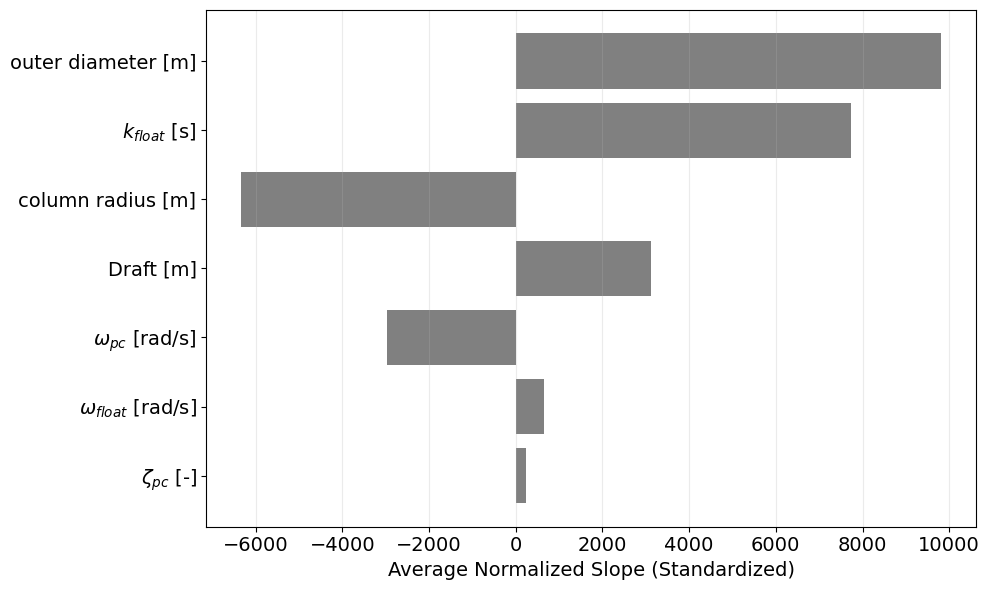

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

channel_slopes = {}

for yv in y_vars:
    x_key = yv[0]
    if x_key == 'aeroelastic_qblade.DEL_TwrBsMyt':
        continue

    slopes = []

    for data in [data1, data2, data3, data4]:
        try:
            X = np.squeeze(data[x_key][:n_iterations])
            y = np.squeeze(data['aeroelastic_qblade.DEL_TwrBsMyt'][:n_iterations])

            if X.ndim > 1:
                X = X[:, dv_column]
            if y.ndim > 1:
                y = y[:, dv_column]

            X = X.reshape(-1, 1)
            y = y.reshape(-1)

            # Standardize X only
            X_scaled = StandardScaler().fit_transform(X)

            model = LinearRegression().fit(X_scaled, y)
            slope = model.coef_[0]
            slopes.append(slope)

        except Exception as e:
            print(f"Error processing {x_key}: {e}")

    if slopes:
        avg_slope = np.mean(slopes)
        channel_slopes[yv[1]] = avg_slope

# Rank by absolute slope
df_ranked = pd.DataFrame(
    sorted(channel_slopes.items(), key=lambda item: abs(item[1]), reverse=True),
    columns=['Channel', 'Avg Normalized Slope']
)

# Print the ranked table
print(df_ranked)

# Plot
plt.figure(figsize=(10, 6))
df_sorted = df_ranked.sort_values(by='Avg Normalized Slope', key=lambda x: abs(x), ascending=True)

plt.barh(df_sorted['Channel'], df_sorted['Avg Normalized Slope'], color='grey')
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel('Average Normalized Slope (Standardized)', fontsize=fontsize)
# plt.title('Channel Influence on TwrBsMyt (Ranked by Standardized Slope)', fontsize=fontsize)
plt.grid(True, axis='x', linestyle='-', alpha=0.25)
plt.tight_layout()
plt.show()
